In [61]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import *
import h5py
from skimage.filters import gaussian

from matplotlib.colors import LinearSegmentedColormap
colors = [(0, 0, 0), (1, 0, 0)] # first color is black, last is red
cm = LinearSegmentedColormap.from_list("Matrix", colors, N = 256)

In [3]:
def read_data_map(file,remove_baseline=False):

    hf = h5py.File(file, 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]

    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0, #Pro sem baseline, raw com baseline
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
    
    new_specs = []
        
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
    
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:,0],positions[:,1]))
    spectrums = spectrums[indexes, :]
    spectrums = np.array(spectrums.reshape((ny,nx,-1)))
    print(spectrums.shape)
    positions = np.array(positions[indexes])
    
    hf.close()
    return spectrums, wavelengths, positions

In [4]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts-w))

In [9]:
fpath = "E:/Data/Data_LIBS/ForHolo/"
fname = "wrench_map"

spectrum, wavelengths, positions = read_data_map(fpath + fname)

(160, 180, 16384)


In [13]:
wavelengths = wavelengths.flatten()

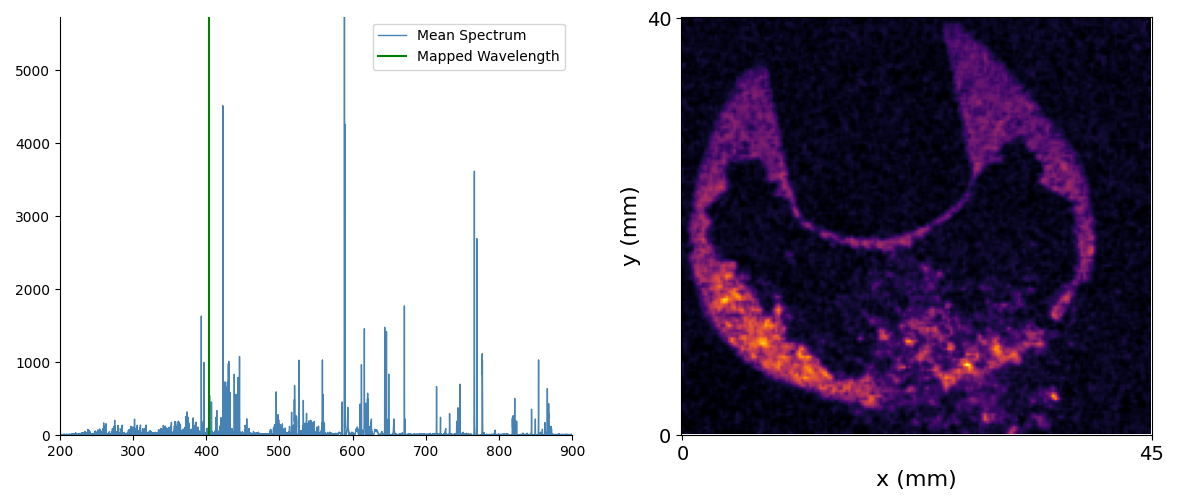

In [67]:
%matplotlib widget
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

mean_spec = spectrum.mean(axis = (0, 1))
wv =  403.23#Mn 403.23 #NA 495.639 #Fe II 259.9 #Fe I 248.7 #NA 766.386

ax = axs[0]
ax.spines[['right', 'top']].set_visible(False)
ax.plot(wavelengths, mean_spec, color = 'steelblue', lw = 1, label = 'Mean Spectrum')
ax.axvline(wv, color = 'green', label = 'Mapped Wavelength')
ax.set_ylim(0, np.max(mean_spec))
ax.set_xlim(200, 900)
ax.legend()

ax = axs[1]
ax.imshow(gaussian(spectrum[:, :, find_index(wavelengths, wv)], sigma = 0.65), cmap = 'inferno', vmin = 0)
x_mm = spectrum.shape[1]
y_mm = spectrum.shape[0]
ax.set_ylabel('y (mm)', fontsize = 16)
ax.set_xlabel('x (mm)', fontsize = 16)
ax.set_xticks([0, x_mm])
ax.set_xticklabels([0, x_mm//4], fontsize = 14)
ax.set_yticks([y_mm, 0])
ax.set_yticklabels([0, y_mm//4], fontsize = 14)

fig.tight_layout()

In [ ]:
from pyevtk.hl import gridToVTK

woi = [403.23, 495.639]
sg = 0.7

for wv in woi: # Change mmap to your generated LIBS map

    scale = 1 # Changes the size of the generated VTK
    spec = gaussian(spectrum[:, :, find_index(wavelengths, wv)], sigma = sg)

    # Dimensions
    nx, ny, nz = spec.shape[0], spec.shape[1], 1
    lx, ly, lz = scale*nx, scale*ny, scale*nz
    dx, dy, dz = lx/nx, ly/ny, lz/nz
    # Coordinates
    X = np.linspace(0, lx, nx)
    Y = np.linspace(0, ly, ny)
    Z = np.linspace(0, lz, nz)
    x = np.zeros((nx, ny, nz))
    y = np.zeros((nx, ny, nz))
    z = np.zeros((nx, ny, nz))

    for k in range(nz):
        for j in range(ny):
            for i in range(nx): 
                x[i,j,k] = X[i] 
                y[i,j,k] = Y[j] 
                z[i,j,k] = Z[k]

    stacked_data = np.stack([spec[wv], spec[wv]], axis = 2)

    gridToVTK(f"wv_{wv}", x, y, z, pointData = {"Libs": stacked_data})